<a href="https://colab.research.google.com/github/fernanda0402/Doutorado/blob/main/An%C3%A1lise_GP_parte_3_dz_0_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fixando um ruído, iremos aplicá-lo mais 3 vezes, pois a cada aplicação do ruído temos um novo conjunto de dados. Iremos também variar dz (0.05, 0.1 e 0.15). Deixei o erro fixo em 1%.

In [1]:
# Bibliotecas:

import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import scipy.interpolate as interp
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.optimize import curve_fit

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install pyccl

In [3]:
import pyccl as ccl

In [ ]:
!pip install git+https://github.com/JCGoran/GaPP@feature/python3#GaPP
from gapp import gp
from numpy import loadtxt, savetxt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

Primeiro caso: dz = 0.05

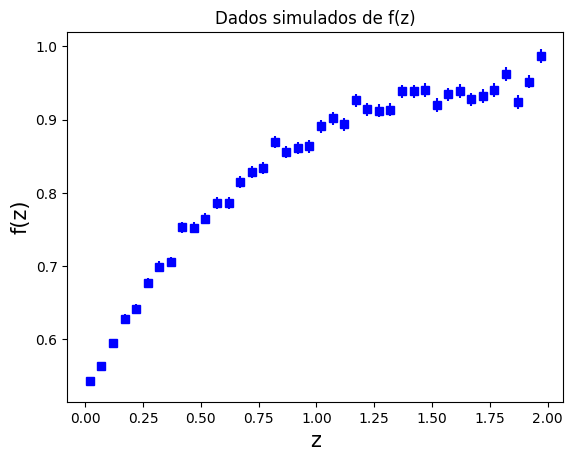

In [10]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')


z = np.arange(0.02, 2, 0.05)

a = 1. / (1. + z)

# fz mocks

fz = ccl.growth_rate(cosmo, a)

efz = 0.01 * fz


fz = np.random.normal(fz, 0.01)

# plote

plt.xlabel('z', fontsize=15)
plt.ylabel('f(z)', fontsize=15)
plt.title('Dados simulados de f(z)')
plt.errorbar(z, fz, efz, fmt='s', color='blue')
plt.show()


# salvando os dados

Nfz = z, fz, efz
#np.savetxt('fz_mocks_c3.dat', np.transpose(Nfz), delimiter='\t')

Vamos para o primeiro conjunto de dados obtido pelo ruído.


Optimized hyperparameters:
theta = [0.80017865 1.67062449]


<ipython-input-11-314660110e7d>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')


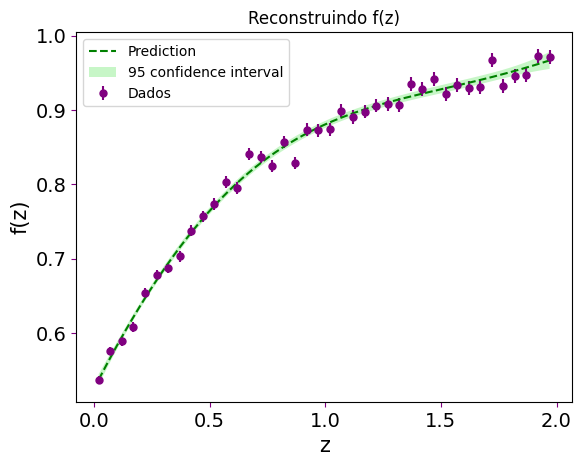

In [11]:
# baixando os dados
data = np.genfromtxt('/content/fz_mocks_c1.dat', delimiter='\t')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'95 confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('f(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo f(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('fz_recon_mock_c1.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [0.80017865 1.67062449]


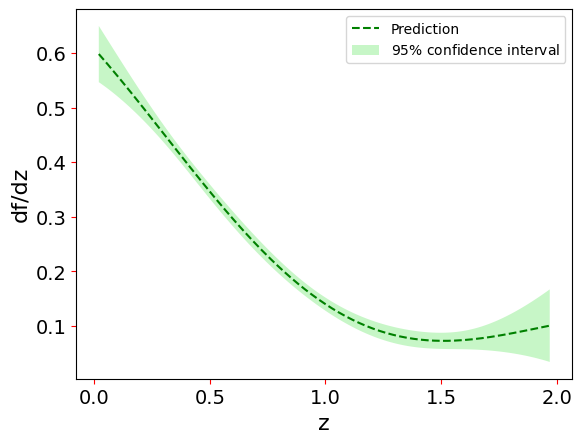

In [12]:
# primeira derivada

from gapp import dgp

# baixando os dados
data = np.genfromtxt('/content/fz_mocks_c1.dat', delimiter='\t')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('dfz_recon_mock_c1.dat', np.transpose(H), delimiter='\t')

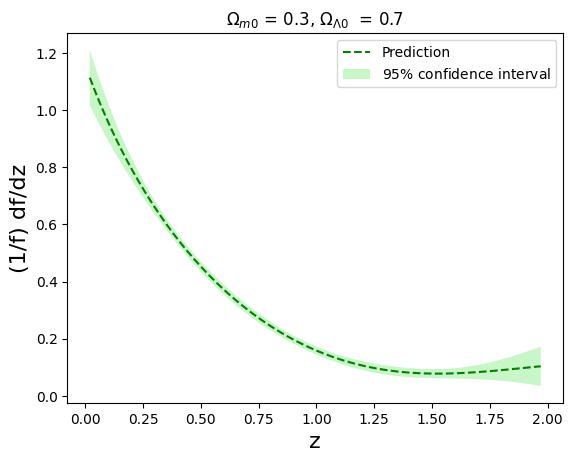

In [37]:
# baixando e nomeando dados
fzrec = np.genfromtxt('/content/fz_recon_mock_c1.dat', delimiter='\t')

z_dgapp = fzrec[:, 0]
f_dgapp = fzrec[:, 1]

ef = fzrec[:, 2]

dfzrec = np.genfromtxt('/content/dfz_recon_mock_c1.dat', delimiter='\t')

df = dfzrec[:, 1]

edf = dfzrec[:, 2]

df_f_c1 = df / f_dgapp

sigma_ff_c1 = np.sqrt(((df_f_c1) ** 2) * (((ef / f_dgapp) ** 2) + ((edf / df) ** 2)))


# PLOTE
plt.plot(z_dgapp, df_f_c1, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dgapp, z_dgapp[::-1]]),
         np.concatenate([df_f_c1 - 1.9600 * sigma_ff_c1,
                        (df_f_c1 + 1.9600 * sigma_ff_c1)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Vamos para o segundo conjunto de dados obtido pelo ruído.


Optimized hyperparameters:
theta = [0.69072072 1.50783601]


<ipython-input-17-6b4fb11f555d>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')


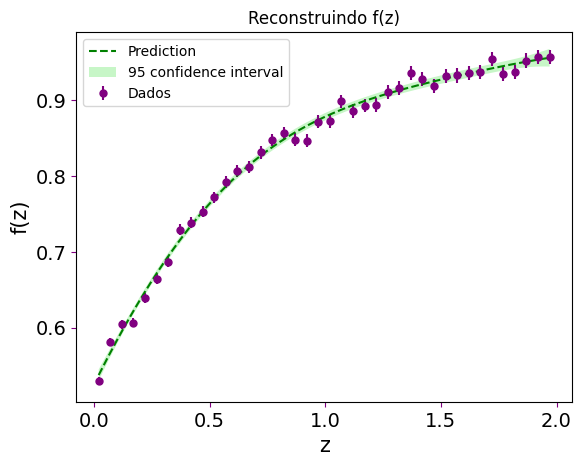

In [17]:
# baixando os dados
data = np.genfromtxt('/content/fz_mocks_c2.dat', delimiter='\t')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'95 confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('f(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo f(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('fz_recon_mock_c2.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [0.69072072 1.50783601]


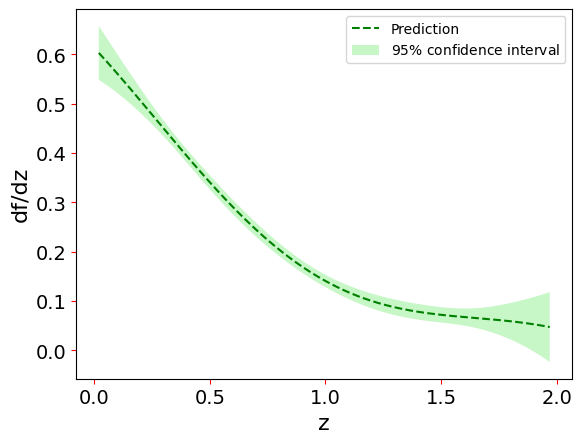

In [22]:
# primeira derivada

from gapp import dgp

# baixando os dados
data = np.genfromtxt('/content/fz_mocks_c2.dat', delimiter='\t')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('dfz_recon_mock_c2.dat', np.transpose(H), delimiter='\t')

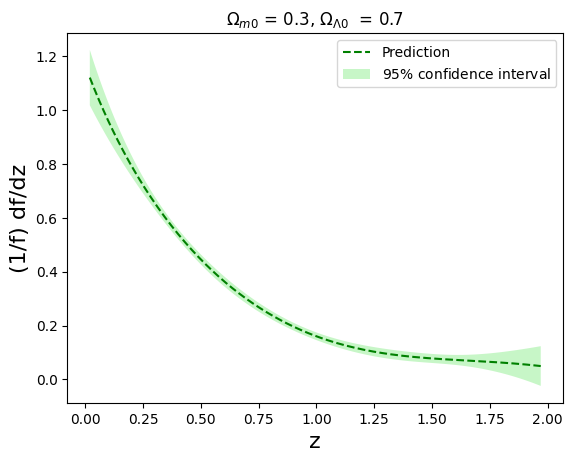

In [38]:
# baixando e nomeando dados
fzrec = np.genfromtxt('/content/fz_recon_mock_c2.dat', delimiter='\t')

z_dgapp = fzrec[:, 0]
f_dgapp = fzrec[:, 1]

ef = fzrec[:, 2]

dfzrec = np.genfromtxt('/content/dfz_recon_mock_c2.dat', delimiter='\t')

df = dfzrec[:, 1]

edf = dfzrec[:, 2]

df_f_c2 = df / f_dgapp

sigma_ff_c2 = np.sqrt(((df_f_c2) ** 2) * (((ef / f_dgapp) ** 2) + ((edf / df) ** 2)))


# PLOTE
plt.plot(z_dgapp, df_f_c2, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dgapp, z_dgapp[::-1]]),
         np.concatenate([df_f_c2 - 1.9600 * sigma_ff_c2,
                        (df_f_c2 + 1.9600 * sigma_ff_c2)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Vamos para o terceiro conjunto de dados obtido pelo ruído.


Optimized hyperparameters:
theta = [0.8518587  1.88075573]


<ipython-input-24-750b3d148ca0>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')


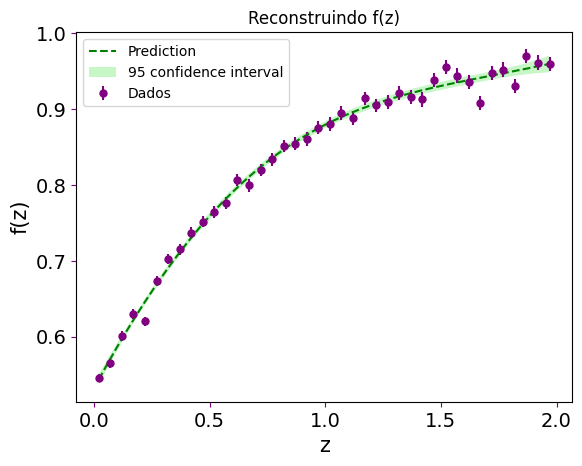

In [24]:
# baixando os dados
data = np.genfromtxt('/content/fz_mocks_c3.dat', delimiter='\t')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_gapp, y_gapp, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'95 confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('f(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo f(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('fz_recon_mock_c3.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [0.8518587  1.88075573]


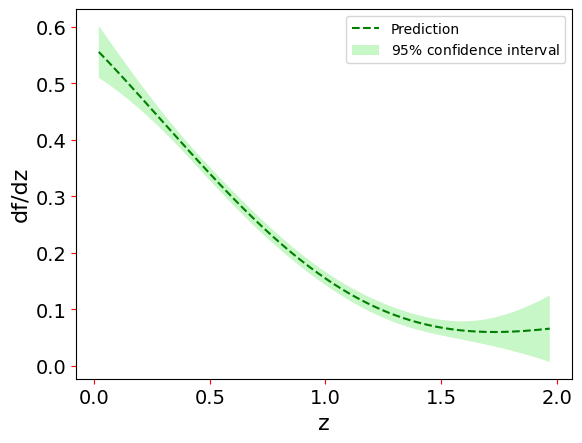

In [25]:
# primeira derivada

from gapp import dgp

# baixando os dados
data = np.genfromtxt('/content/fz_mocks_c3.dat', delimiter='\t')

z_gapp = data[:, 0]

f_gapp = data[:, 1]

sig_f = data[:, 2]

# nomeando
x_gapp = z_gapp
y_gapp = f_gapp
e = sig_f

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_gapp)
xmax = max(x_gapp)
nstar = 200

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_gapp, y_gapp, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('dfz_recon_mock_c3.dat', np.transpose(H), delimiter='\t')

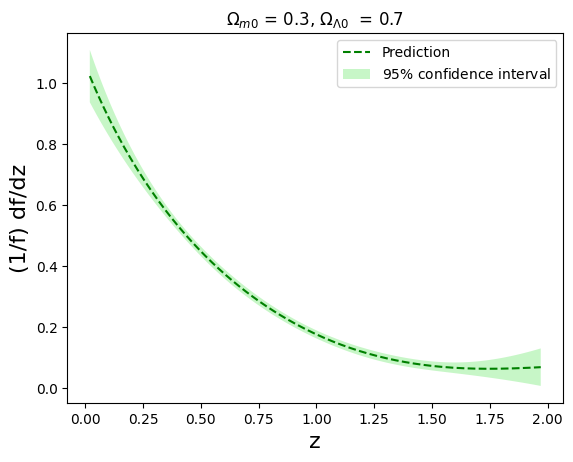

In [39]:
# baixando e nomeando dados
fzrec = np.genfromtxt('/content/fz_recon_mock_c3.dat', delimiter='\t')

z_dgapp = fzrec[:, 0]
f_dgapp = fzrec[:, 1]

ef = fzrec[:, 2]

dfzrec = np.genfromtxt('/content/dfz_recon_mock_c3.dat', delimiter='\t')

df = dfzrec[:, 1]

edf = dfzrec[:, 2]

df_f_c3 = df / f_dgapp

sigma_ff_c3 = np.sqrt(((df_f_c3) ** 2) * (((ef / f_dgapp) ** 2) + ((edf / df) ** 2)))


# PLOTE
plt.plot(z_dgapp, df_f_c3, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dgapp, z_dgapp[::-1]]),
         np.concatenate([df_f_c3 - 1.9600 * sigma_ff_c3,
                        (df_f_c3 + 1.9600 * sigma_ff_c3)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.title('$\Omega_{m0}$ = 0.3, $\Omega_{\Lambda 0}$  = 0.7 ')
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/f) df/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Vamos fazer agora para os dados de H(z).

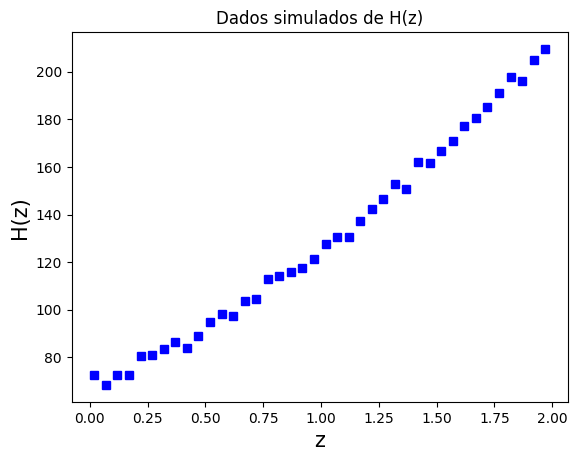

In [26]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, h=0.6727, sigma8=0.8120, n_s=0.9649,
    matter_power_spectrum='linear')


z = np.arange(0.02, 2, 0.05)

a = 1. / (1. + z)

# hz mocks
H0 = 70

Hz = H0 * ccl.background.h_over_h0(cosmo, a)

ehz = 0.01 * Hz


Hz = np.random.normal(Hz, 2)

# plote

plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.title('Dados simulados de H(z)')
plt.errorbar(z, Hz, efz, fmt='s', color='blue')
plt.show()


# salvando os dados

NHz = z, Hz, ehz
#np.savetxt('Hz_mocks_c3.dat', np.transpose(NHz), delimiter='\t')

Vamos fazer para o primeiro conjunto de dados de H(z).


Optimized hyperparameters:
theta = [248.64436322   3.50066045]


<ipython-input-28-843c131c3b51>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')


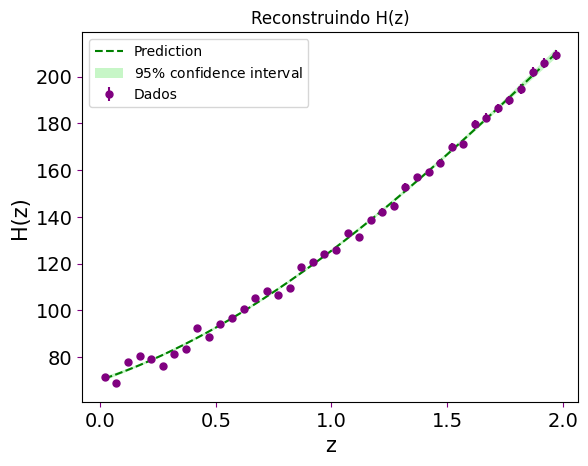

In [28]:
# baixando os dados
data_h = np.genfromtxt('/content/Hz_mocks_c1.dat', delimiter='\t')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_h)
xmax = max(x_h)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo H(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('hz_recon_mock_c1.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [248.64436322   3.50066045]


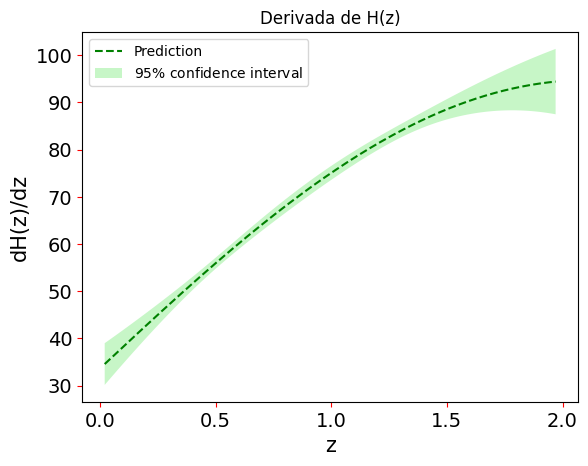

In [29]:
# primeira derivada

from gapp import dgp

# baixando os dados
data_h = np.genfromtxt('/content/Hz_mocks_c1.dat', delimiter='\t')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_h)
xmax = max(x_h)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('dH(z)/dz', fontsize=15)
plt.legend(loc='best')
plt.title('Derivada de H(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('dhz_recon_mock_c1.dat', np.transpose(H), delimiter='\t')

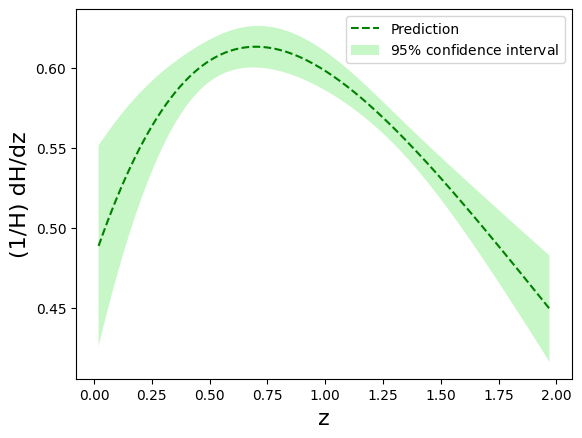

In [47]:
# baixando e nomeando dados reconstruídos de H
hz = np.genfromtxt('/content/hz_recon_mock_c1.dat', delimiter='\t')

z_hz = hz[:, 0]
h_hz = hz[:, 1]

ehz = hz[:, 2]

# baixando e nomeando dados reconstruídos da derivada de H
dhz = np.genfromtxt('/content/dhz_recon_mock_c1.dat', delimiter='\t')

z_dhz = dhz[:, 0]

dh = dhz[:, 1]

edh = dhz[:, 2]

dh_h_c1 = dh / h_hz  # H'/H

sigma_H_c1 = np.sqrt(((dh_h_c1) ** 2) * (((ehz / h_hz) ** 2) + ((edh / dh) ** 2)))


# PLOTE
plt.plot(z_dhz, dh_h_c1, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([dh_h_c1 - 1.9600 * sigma_H_c1,
                        (dh_h_c1 + 1.9600 * sigma_H_c1)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/H) dH/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

Usaremos o que obtivemos de $H'/H$ para plotar $\frac{\Omega_m '}{\Omega_m}$.

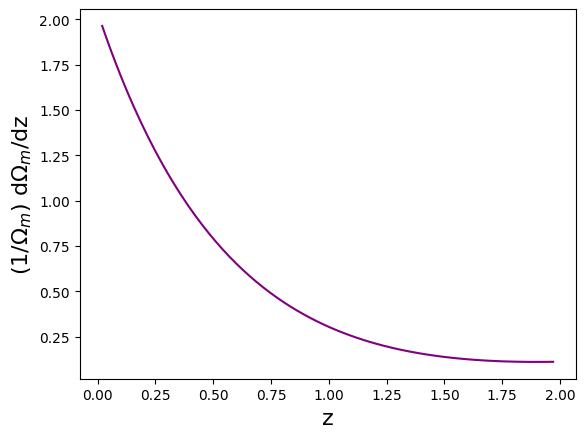

In [48]:
# definindo Om'/Om

dOm_Om_c1 = (3/(1+z_dhz)) - (2*dh_h_c1)   #dh_h vem da reconstrução dos dados

eOm_c1 = np.sqrt( (2*sigma_H_c1)**2 )

plt.plot(z_dhz, dOm_Om_c1, color='purple')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/$\Omega_m$) d$\Omega_m$/dz', fontsize=16)
plt.show()

Vamos para o segundo conjunto de dados de H(z).


Optimized hyperparameters:
theta = [446.92147877   5.25357039]


<ipython-input-40-cdfa2677d9e9>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')


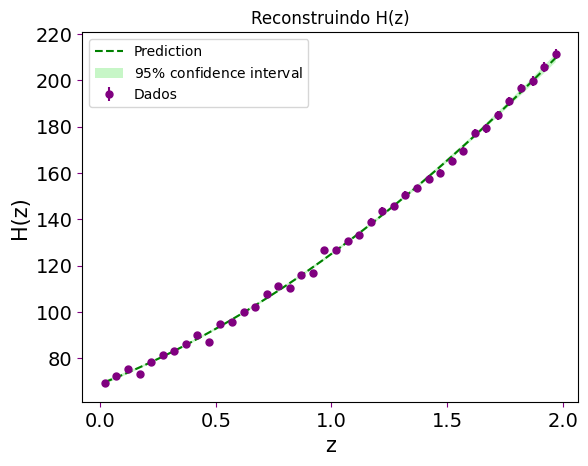

In [40]:
# baixando os dados
data_h = np.genfromtxt('/content/Hz_mocks_c2.dat', delimiter='\t')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_h)
xmax = max(x_h)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo H(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('hz_recon_mock_c2.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [446.92147877   5.25357039]


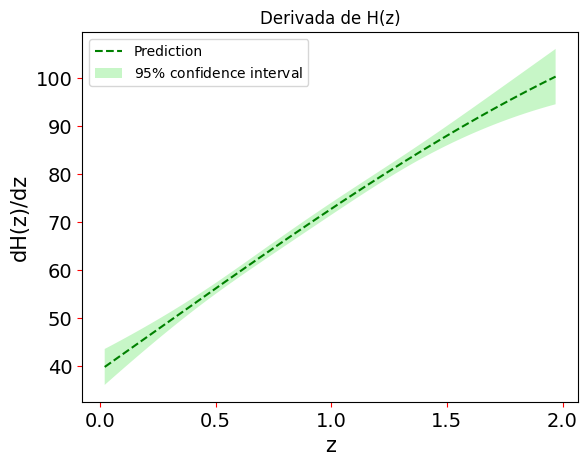

In [41]:
# primeira derivada

from gapp import dgp

# baixando os dados
data_h = np.genfromtxt('/content/Hz_mocks_c2.dat', delimiter='\t')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_h)
xmax = max(x_h)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('dH(z)/dz', fontsize=15)
plt.legend(loc='best')
plt.title('Derivada de H(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('dhz_recon_mock_c2.dat', np.transpose(H), delimiter='\t')

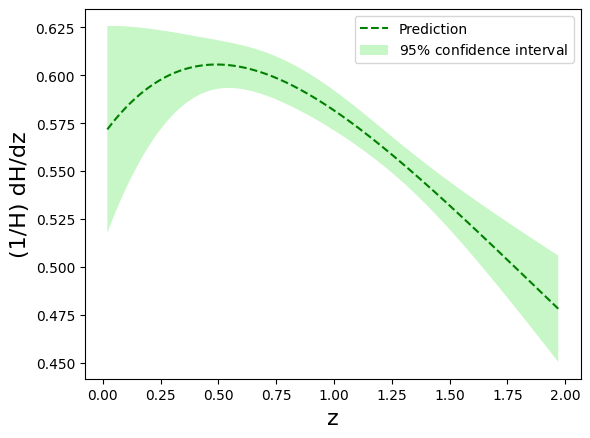

In [49]:
# baixando e nomeando dados reconstruídos de H
hz = np.genfromtxt('/content/hz_recon_mock_c2.dat', delimiter='\t')

z_hz = hz[:, 0]
h_hz = hz[:, 1]

ehz = hz[:, 2]

# baixando e nomeando dados reconstruídos da derivada de H
dhz = np.genfromtxt('/content/dhz_recon_mock_c2.dat', delimiter='\t')

z_dhz = dhz[:, 0]

dh = dhz[:, 1]

edh = dhz[:, 2]

dh_h_c2 = dh / h_hz  # H'/H

sigma_H_c2 = np.sqrt(((dh_h_c2) ** 2) * (((ehz / h_hz) ** 2) + ((edh / dh) ** 2)))


# PLOTE
plt.plot(z_dhz, dh_h_c2, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([dh_h_c2 - 1.9600 * sigma_H_c2,
                        (dh_h_c2 + 1.9600 * sigma_H_c2)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/H) dH/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

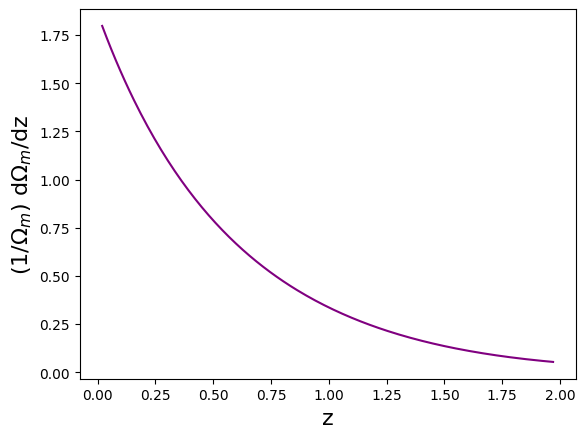

In [50]:
# definindo Om'/Om

dOm_Om_c2 = (3/(1+z_dhz)) - (2*dh_h_c2)   #dh_h vem da reconstrução dos dados

eOm_c2 = np.sqrt( (2*sigma_H_c2)**2 )

plt.plot(z_dhz, dOm_Om_c2, color='purple')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/$\Omega_m$) d$\Omega_m$/dz', fontsize=16)
plt.show()

Vamos para o terceiro conjunto de dados de H(z).


Optimized hyperparameters:
theta = [212.99397108   2.81713945]


<ipython-input-43-703c2736fe93>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')


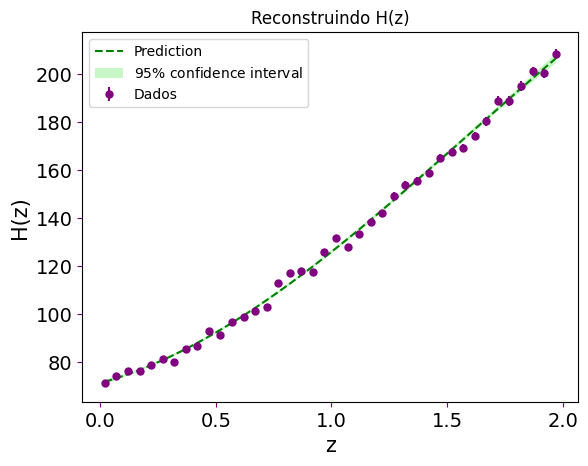

In [43]:
# baixando os dados
data_h = np.genfromtxt('/content/Hz_mocks_c3.dat', delimiter='\t')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_h)
xmax = max(x_h)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[:, 0]

y_pred = rec[:, 1]
sigma  = rec[:, 2]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14, color='purple')
plt.errorbar(x_h, y_h, e, fmt='r.', color='purple', markersize=10, label='Dados')
plt.plot(xi, y_pred, color = 'green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, color = 'lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('H(z)', fontsize=15)
plt.legend(loc='best')
plt.title('Reconstruindo H(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('hz_recon_mock_c3.dat', np.transpose(H), delimiter='\t')


Optimized hyperparameters:
theta = [212.99397108   2.81713945]


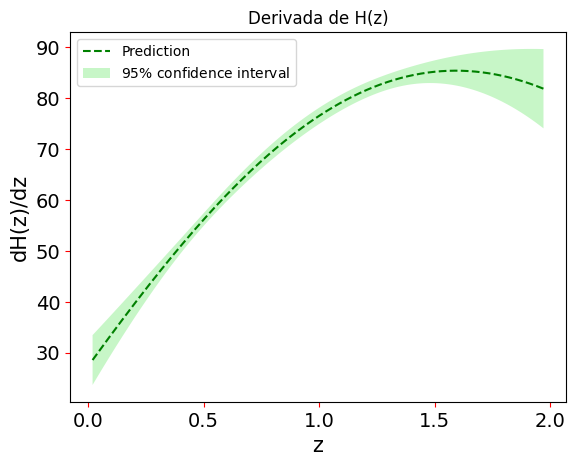

In [44]:
# primeira derivada

from gapp import dgp

# baixando os dados
data_h = np.genfromtxt('/content/Hz_mocks_c3.dat', delimiter='\t')

z_h = data_h[:, 0]

h = data_h[:, 1]

sig_h = data_h[:, 2]

# nomeando
x_h = z_h
y_h = h
e = sig_h

# xmin, xmax and nstar are interpreted as two-dimensional vectors
xmin = min(x_h)
xmax = max(x_h)
nstar = 200

# initial values of the hyperparameters of the squared-exponential covariance function
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = dgp.DGaussianProcess(x_h, y_h, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(drec, theta) = g.dgp(theta=initheta)

xi     = drec[:, 0]
y_pred = drec[:, 1]
sigma  = drec[:, 2]

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.tick_params(labelsize=14,color='red')
plt.plot(xi, y_pred, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label=r'$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('dH(z)/dz', fontsize=15)
plt.legend(loc='best')
plt.title('Derivada de H(z)')
plt.show()

H = xi, y_pred, sigma

#np.savetxt('dhz_recon_mock_c3.dat', np.transpose(H), delimiter='\t')

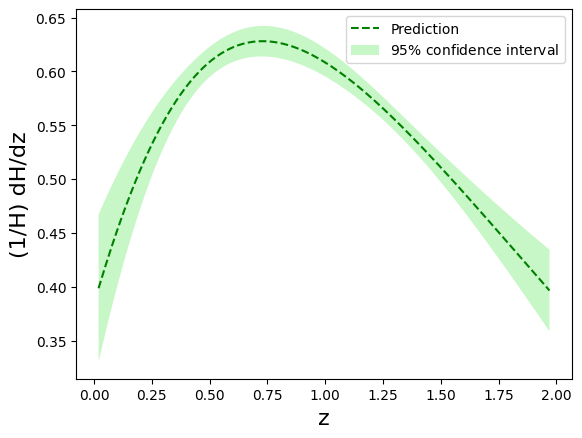

In [51]:
# baixando e nomeando dados reconstruídos de H
hz = np.genfromtxt('/content/hz_recon_mock_c3.dat', delimiter='\t')

z_hz = hz[:, 0]
h_hz = hz[:, 1]

ehz = hz[:, 2]

# baixando e nomeando dados reconstruídos da derivada de H
dhz = np.genfromtxt('/content/dhz_recon_mock_c3.dat', delimiter='\t')

z_dhz = dhz[:, 0]

dh = dhz[:, 1]

edh = dhz[:, 2]

dh_h_c3 = dh / h_hz  # H'/H

sigma_H_c3 = np.sqrt(((dh_h_c3) ** 2) * (((ehz / h_hz) ** 2) + ((edh / dh) ** 2)))


# PLOTE
plt.plot(z_dhz, dh_h_c3, color='green', label='Prediction', linestyle="--")
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([dh_h_c3 - 1.9600 * sigma_H_c3,
                        (dh_h_c3 + 1.9600 * sigma_H_c3)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/H) dH/dz', fontsize=16)
plt.legend(loc='best')
plt.show()

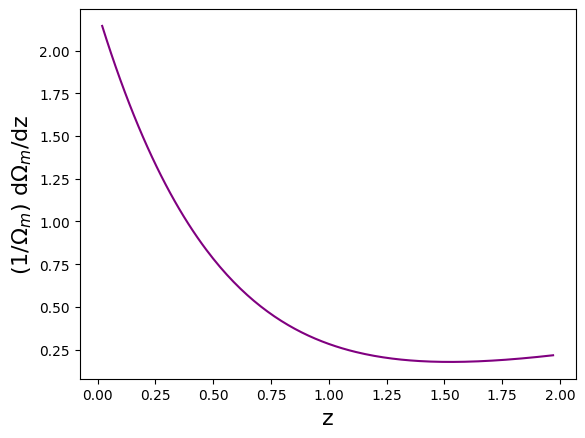

In [52]:
# definindo Om'/Om

dOm_Om_c3 = (3/(1+z_dhz)) - (2*dh_h_c3)   #dh_h vem da reconstrução dos dados

eOm_c3 = np.sqrt( (2*sigma_H_c3)**2 )

plt.plot(z_dhz, dOm_Om_c3, color='purple')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('(1/$\Omega_m$) d$\Omega_m$/dz', fontsize=16)
plt.show()

$\gamma$ para o primeiro conjunto de dados de $f$ e H(z).

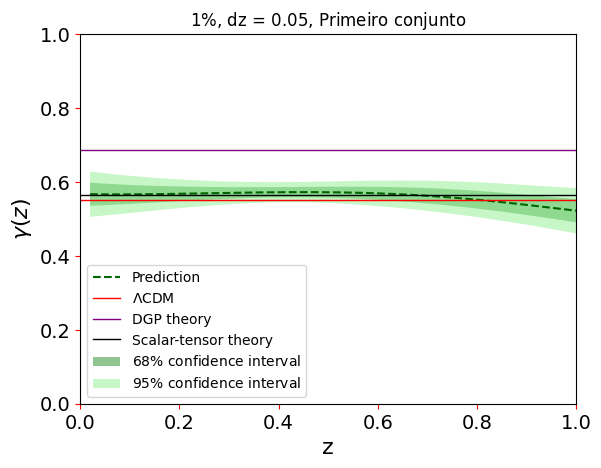

In [54]:
# gamma prediction

gamma_pred_c1 = df_f_c1 / dOm_Om_c1

sigma_g_c1 = np.sqrt( (sigma_ff_c1 / dOm_Om_c1 )**2 + ( ( (df_f_c1*eOm_c1)/ ((dOm_Om_c1)**2) ) )**2)


# gamma lcdm
gamma_lcdm = 0.55

# gamma dgp
gamma_dgp = 0.6875

# gamma scalar tensor
gamma_st = 0.564

# PLOTE

fig, ax = plt.subplots()
plt.ylim(0,1)
plt.xlim(0,1.0)
plt.tick_params(labelsize=14, color='red')
plt.plot(z_dhz, gamma_pred_c1, color='darkgreen', label='Prediction', linestyle="--")
plt.axhline(y=0.55, color='red', linestyle='-', linewidth=1, label='$\Lambda$CDM')
plt.axhline(y=0.6875, color='purple', linestyle='-', linewidth=1, label='DGP theory')
plt.axhline(y=0.564, color='black', linestyle='-', linewidth=1, label='Scalar-tensor theory')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_pred_c1 - 1.0000 * sigma_g_c1,
                        (gamma_pred_c1 + 1.0000 * sigma_g_c1)[::-1]]),
         alpha=.5, fc='forestgreen', ec='None', label='$68\%$ confidence interval')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_pred_c1 - 1.9600 * sigma_g_c1,
                        (gamma_pred_c1 + 1.9600 * sigma_g_c1)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('$\gamma(z)$', fontsize=16)
plt.legend(loc='best')
#plt.savefig('gamma_cte.pdf')
plt.title('$1\%$, dz = 0.05, Primeiro conjunto')
plt.show()

$\gamma$ para o segundo conjunto de dados de $f$ e H(z).

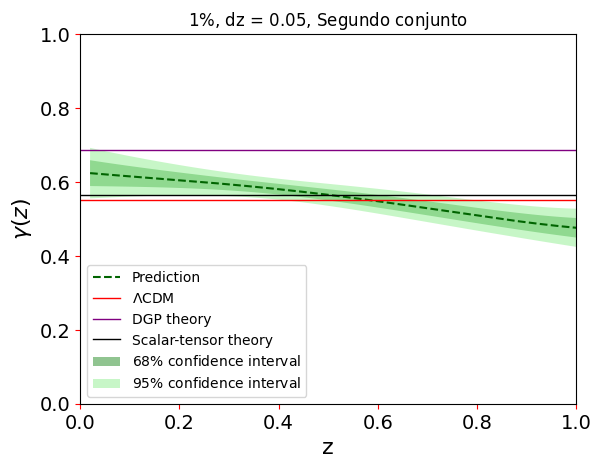

In [58]:
# gamma prediction

gamma_pred_c2 = df_f_c2 / dOm_Om_c2

sigma_g_c2 = np.sqrt( (sigma_ff_c2 / dOm_Om_c2 )**2 + ( ( (df_f_c2*eOm_c2)/ ((dOm_Om_c2)**2) ) )**2)


# gamma lcdm
gamma_lcdm = 0.55

# gamma dgp
gamma_dgp = 0.6875

# gamma scalar tensor
gamma_st = 0.564

# PLOTE

fig, ax = plt.subplots()
plt.ylim(0,1)
plt.xlim(0,1.0)
plt.tick_params(labelsize=14, color='red')
plt.plot(z_dhz, gamma_pred_c2, color='darkgreen', label='Prediction', linestyle="--")
plt.axhline(y=0.55, color='red', linestyle='-', linewidth=1, label='$\Lambda$CDM')
plt.axhline(y=0.6875, color='purple', linestyle='-', linewidth=1, label='DGP theory')
plt.axhline(y=0.564, color='black', linestyle='-', linewidth=1, label='Scalar-tensor theory')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_pred_c2 - 1.0000 * sigma_g_c2,
                        (gamma_pred_c2 + 1.0000 * sigma_g_c2)[::-1]]),
         alpha=.5, fc='forestgreen', ec='None', label='$68\%$ confidence interval')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_pred_c2 - 1.9600 * sigma_g_c2,
                        (gamma_pred_c2 + 1.9600 * sigma_g_c2)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('$\gamma(z)$', fontsize=16)
plt.legend(loc='best')
#plt.savefig('gamma_cte.pdf')
plt.title('$1\%$, dz = 0.05, Segundo conjunto')
plt.show()

$\gamma$ para o terceiro conjunto de dados de $f$ e H(z).

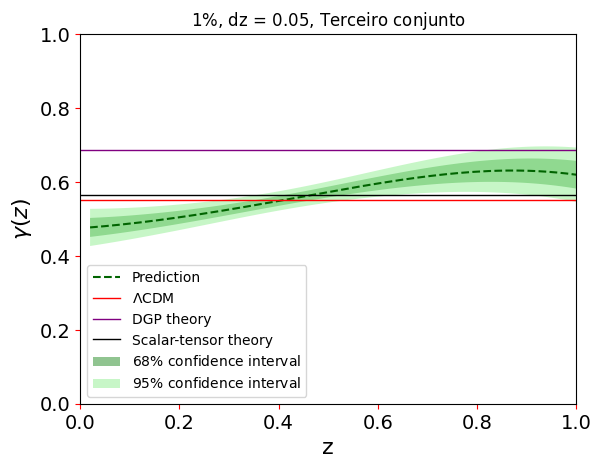

In [59]:
# gamma prediction

gamma_pred_c3 = df_f_c3 / dOm_Om_c3

sigma_g_c3 = np.sqrt( (sigma_ff_c3 / dOm_Om_c3 )**2 + ( ( (df_f_c3*eOm_c3)/ ((dOm_Om_c3)**2) ) )**2)


# gamma lcdm
gamma_lcdm = 0.55

# gamma dgp
gamma_dgp = 0.6875

# gamma scalar tensor
gamma_st = 0.564

# PLOTE

fig, ax = plt.subplots()
plt.ylim(0,1)
plt.xlim(0,1.0)
plt.tick_params(labelsize=14, color='red')
plt.plot(z_dhz, gamma_pred_c3, color='darkgreen', label='Prediction', linestyle="--")
plt.axhline(y=0.55, color='red', linestyle='-', linewidth=1, label='$\Lambda$CDM')
plt.axhline(y=0.6875, color='purple', linestyle='-', linewidth=1, label='DGP theory')
plt.axhline(y=0.564, color='black', linestyle='-', linewidth=1, label='Scalar-tensor theory')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_pred_c3 - 1.0000 * sigma_g_c3,
                        (gamma_pred_c3 + 1.0000 * sigma_g_c3)[::-1]]),
         alpha=.5, fc='forestgreen', ec='None', label='$68\%$ confidence interval')
plt.fill(np.concatenate([z_dhz, z_dhz[::-1]]),
         np.concatenate([gamma_pred_c3 - 1.9600 * sigma_g_c3,
                        (gamma_pred_c3 + 1.9600 * sigma_g_c3)[::-1]]),
         alpha=.5, fc='lightgreen', ec='None', label='$95\%$ confidence interval')

# legenda, label e título
plt.xlabel('z', fontsize=16)
plt.ylabel('$\gamma(z)$', fontsize=16)
plt.legend(loc='best')
#plt.savefig('gamma_cte.pdf')
plt.title('$1\%$, dz = 0.05, Terceiro conjunto')
plt.show()